In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
import numpy as np
from matplotlib.pyplot import *
import npp

In [3]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

In [4]:
%load_ext autoreload
%autoreload 2

## Create fake dataset with specific variance properties

In [173]:
def make_params():
    # partitions are always listed in the order (A, B, C, AB, AC, BC, ABC)
    part_names = ('A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC')

    # which partitions are combined to get each full feature space?
    combs = [[0, 3, 4, 6],
             [1, 3, 5, 6],
             [2, 4, 5, 6]]

    # total_variance is total fraction of non-noise variance in responses
    total_variance = 0.02

    # true_variances is proportion of variance assigned to each partition
    #true_variances = np.ones(7) # each partition is equal
    #true_variances = np.array([1088, 662, 9501, 251, 284, 1872, 555]).astype(float) # values from speech experiment
    true_variances = np.array([1088, 0, 0, 251, 284, 1872, 555]).astype(float) # values from speech experiment
    #true_variances = np.array([1, 1, 1, 1, 1, 1, 1])
    true_variances = true_variances / float(true_variances.sum()) * total_variance

    noise_variance = 1.0 - true_variances.sum()

    # P_parts is number of components that together describe the variance in each partition
    #P_parts = [1] * 7 # 1 component in each partition
    #P_parts = [10] * 7 # 10 component in each partition
    #P_parts = [10, 10, 900, 10, 10, 10, 10]
    P_parts = [1, 1, 10, 1, 1, 1, 2]

    # P_models contains size of each feature space (each must be bigger than sum of constituent parts)
    P_models = [300, 22, 985] # like speech experiment
    #P_models = [1200, 88, 3940] # REALLY like speech experiment
    #P_models = [50, 50, 50]
    #P_models = [9, 5, 19] # like Mark's experiment

    # Pnoise_models is number of noise features in each feature space
    Pnoise_models = [P - np.array(P_parts)[c].sum() for P,c in zip(P_models, combs)]

    # N_R is number of training (regression) timepoints, N_P is number of validation (prediction) timepoints
    #N_R, N_P = 3737, 300 # like speech experiment
    N_R, N_P = 1260, 126 # like Mark's experiment

    # M is number of voxels to simulate
    M = 1000

    data_params = locals()
    return data_params

data_params = make_params()

In [174]:
from varpart import make_data, compare

# Create dataset
data = make_data(use_mixing=True, orthogonalize=True, noise_scale=1.0, **data_params)

X_parts[0].shape (1, 1386)
Btrue_parts[0].shape (1, 1000)
Y_parts[0].shape (1386, 1000)
scaled_Y_parts[0].shape (1386, 1000)
scaled_Y_noise.shape (1386, 1000)
Y_total.shape (1386, 1000)
Xtrue_feats[0].shape (5, 1386)
Xnoise_feats[0].shape (295, 1386)
mixing_mats[0].shape (300, 300)
X_feats[0].shape (300, 1386)
bulked_X_feats[0].shape (985, 1386)


## Compare correlation ($r^2$) vs. coefficient of determination ($R^2$)

corr MSE: Orig: 0.000167, Fixed: 0.000031, Ratio: fixed 5.457x better
Rsq MSE:  Orig: 0.003547, Fixed: 0.000022, Ratio: fixed 158.495x better

corr vs. Rsq fixed MSE: corr 0.732x better

corr Variance: Orig: 0.000136, Fixed: 0.000016, Ratio: fixed 8.314x better
Rsq Variance: Orig: 0.001240, Fixed: 0.000007, Ratio: fixed 186.390x better

corr vs. Rsq fixed variance: corr 0.407x better

corr Bias: 
Orig: [-0.00460357  0.00121701 -0.00199433 -0.00132878 -0.00895409 -0.0075647
  0.00706174], 
Fixed: [-0.00288958  0.00294597  0.00255027 -0.00028085 -0.00121795 -0.00828702
 -0.00238314], 
Ratio: fixed 1.592x better

Rsq Bias: 
Orig: [-0.00533684 -0.00013069  0.02064107  0.08268098 -0.01994197 -0.00600491
 -0.09180213], 
Fixed: [-0.00384417  0.00155708  0.00031653 -0.00041373 -0.00137951 -0.00913336
 -0.00270326], 
Ratio: fixed 11.709x better

corr vs. Rsq fixed bias: corr 0.941x better


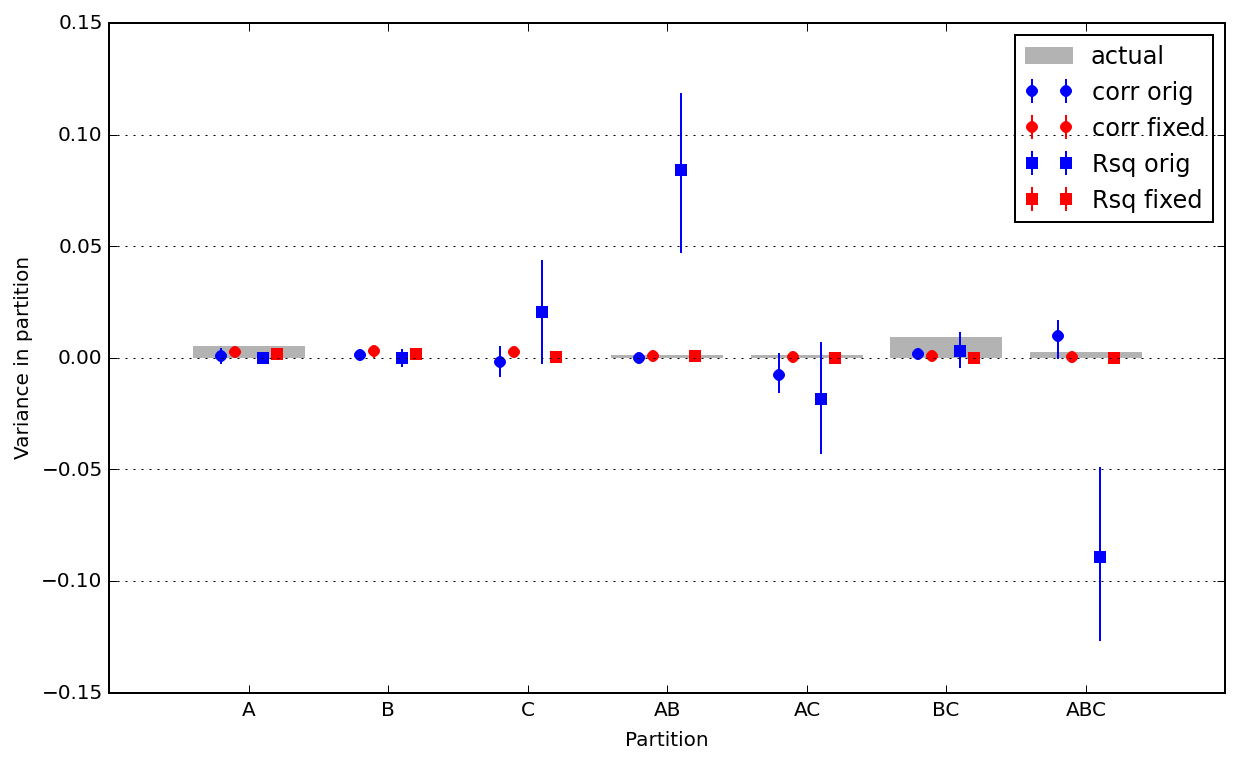

In [175]:
compare(dict(metric="corr"), dict(metric="rsq"), "corr", "Rsq", 
        data_params, data, verbose=False, nboots=10)

## Compare ridge regression vs. ordinary least squares (OLS)

ridge MSE: Orig: 0.000058, Fixed: 0.000024, Ratio: fixed 2.389x better
ols MSE:  Orig: 0.000060, Fixed: 0.000025, Ratio: fixed 2.427x better

ridge vs. ols fixed MSE: ridge 1.007x better

ridge Variance: Orig: 0.000033, Fixed: 0.000005, Ratio: fixed 6.667x better
ols Variance: Orig: 0.000032, Fixed: 0.000005, Ratio: fixed 6.971x better

ridge vs. ols fixed variance: ridge 0.938x better

ridge Bias: 
Orig: [-0.00150711 -0.00055928 -0.01253986 -0.00022251 -0.002975   -0.00183968
  0.00284661], 
Fixed: [ -3.92079985e-04   4.30722800e-04  -1.14603618e-02  -4.44593444e-05
  -2.44403848e-04  -2.12297368e-03  -5.33033223e-04], 
Ratio: fixed 1.477x better

ols Bias: 
Orig: [-0.00177619 -0.00090736 -0.01313062 -0.00019406 -0.00270272 -0.00149199
  0.00281308], 
Fixed: [ -4.06809902e-04   1.37116180e-04  -1.16242073e-02  -8.40604756e-05
  -1.76253153e-04  -2.06476811e-03  -5.09800294e-04], 
Ratio: fixed 1.534x better

ridge vs. ols fixed bias: ridge 0.985x better


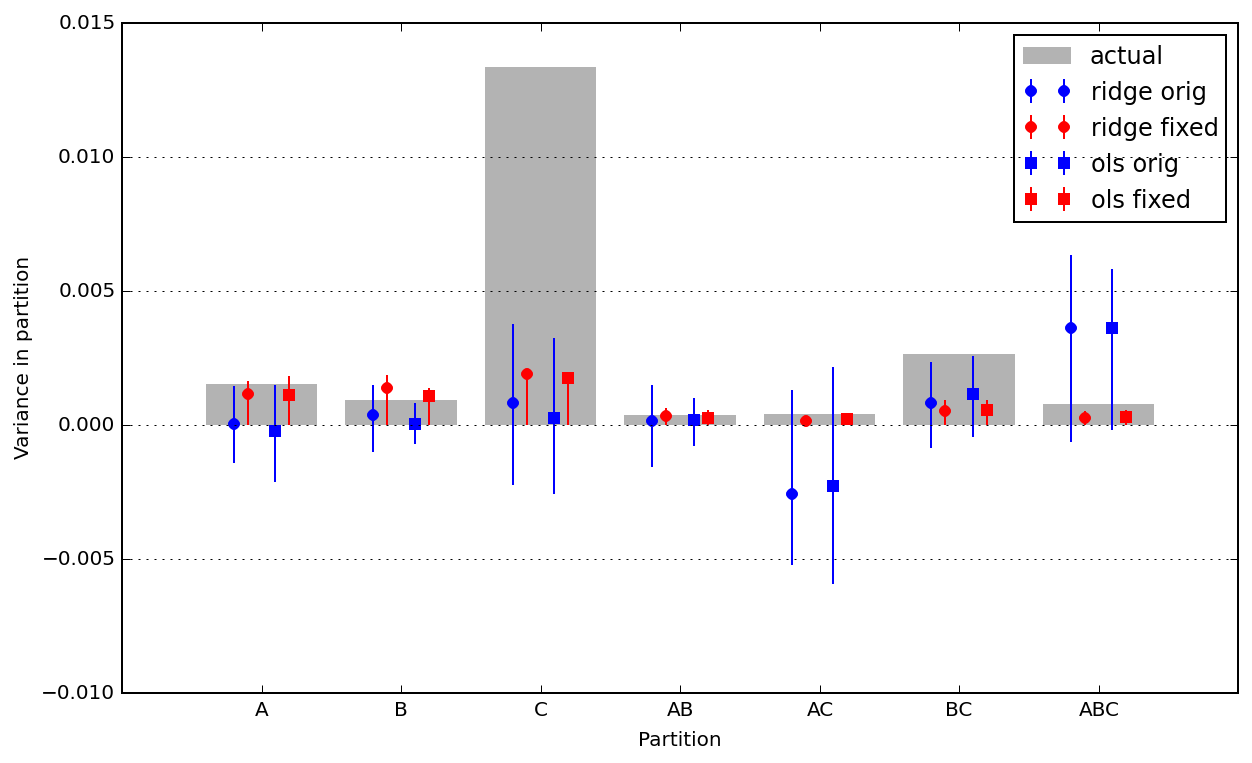

In [168]:
compare(dict(use_ols=False), dict(use_ols=True), "ridge", "ols", 
        data_params, data, verbose=False, nboots=10)

## Compare correction with unconstrained bias vs. negative-only bias

uncons-bias MSE: Orig: 0.000067, Fixed: 0.000024, Ratio: fixed 2.725x better
negonly-bias MSE:  Orig: 0.000064, Fixed: 0.000032, Ratio: fixed 2.002x better

uncons-bias vs. negonly-bias fixed MSE: uncons-bias 1.303x better

uncons-bias Variance: Orig: 0.000041, Fixed: 0.000005, Ratio: fixed 8.380x better
negonly-bias Variance: Orig: 0.000038, Fixed: 0.000013, Ratio: fixed 2.908x better

uncons-bias vs. negonly-bias fixed variance: uncons-bias 2.679x better

uncons-bias Bias: 
Orig: [-0.0013742  -0.00048841 -0.01253986 -0.00042629 -0.00310759 -0.00191055
  0.00305007], 
Fixed: [ -3.78174338e-04   3.95681450e-04  -1.15042284e-02  -8.78133151e-05
  -2.25308214e-04  -2.10730430e-03  -5.29494729e-04], 
Ratio: fixed 1.504x better

negonly-bias Bias: 
Orig: [-0.0013742  -0.00055928 -0.01256792 -0.00041525 -0.00307952 -0.00181162
  0.00301096], 
Fixed: [ 0.00024159  0.00281246 -0.01100505  0.00019442 -0.00018053 -0.00165915
 -0.00058451], 
Ratio: fixed 1.368x better

uncons-bias vs. negonly-bi

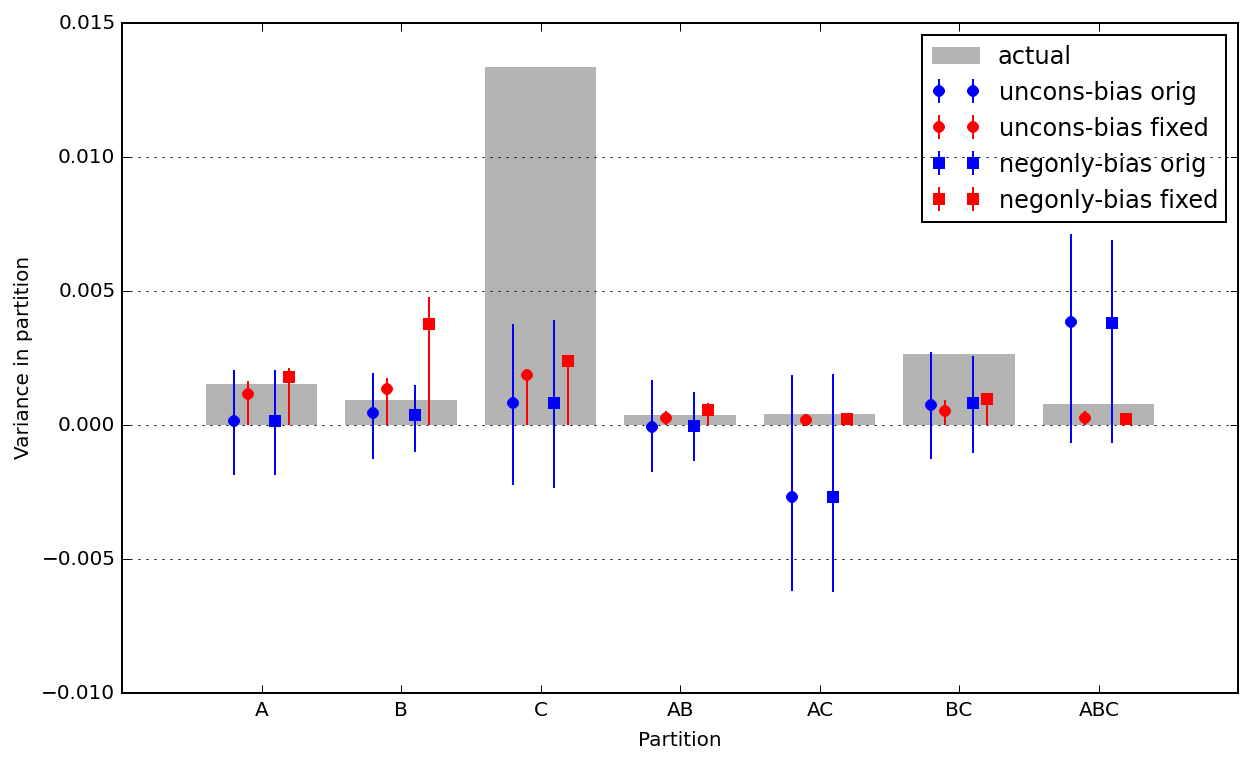

In [169]:
compare(dict(neg_only=False), dict(neg_only=True), "uncons-bias", "negonly-bias", 
        data_params, data, verbose=False)

## Compare bulked features vs. raw features

bulked MSE: Orig: 0.000046, Fixed: 0.000024, Ratio: fixed 1.938x better
raw MSE:  Orig: 0.000064, Fixed: 0.000024, Ratio: fixed 2.607x better

bulked vs. raw fixed MSE: bulked 1.036x better

bulked Variance: Orig: 0.000025, Fixed: 0.000004, Ratio: fixed 6.462x better
raw Variance: Orig: 0.000038, Fixed: 0.000005, Ratio: fixed 7.764x better

bulked vs. raw fixed variance: bulked 1.282x better

bulked Bias: 
Orig: [-0.00149552 -0.0007807  -0.0118267  -0.000596   -0.0002676  -0.00229176
 -0.00012562], 
Fixed: [-0.00041805  0.00013305 -0.0114824  -0.00020764 -0.00023847 -0.00242475
 -0.00070701], 
Ratio: fixed 1.114x better

raw Bias: 
Orig: [-0.0013742  -0.00055928 -0.01253986 -0.00035113 -0.00310759 -0.00183779
  0.00297302], 
Fixed: [ -3.75893781e-04   3.08834531e-04  -1.14871036e-02  -5.10948539e-05
  -2.21367111e-04  -2.10699237e-03  -5.09599697e-04], 
Ratio: fixed 1.510x better

bulked vs. raw fixed bias: bulked 0.965x better


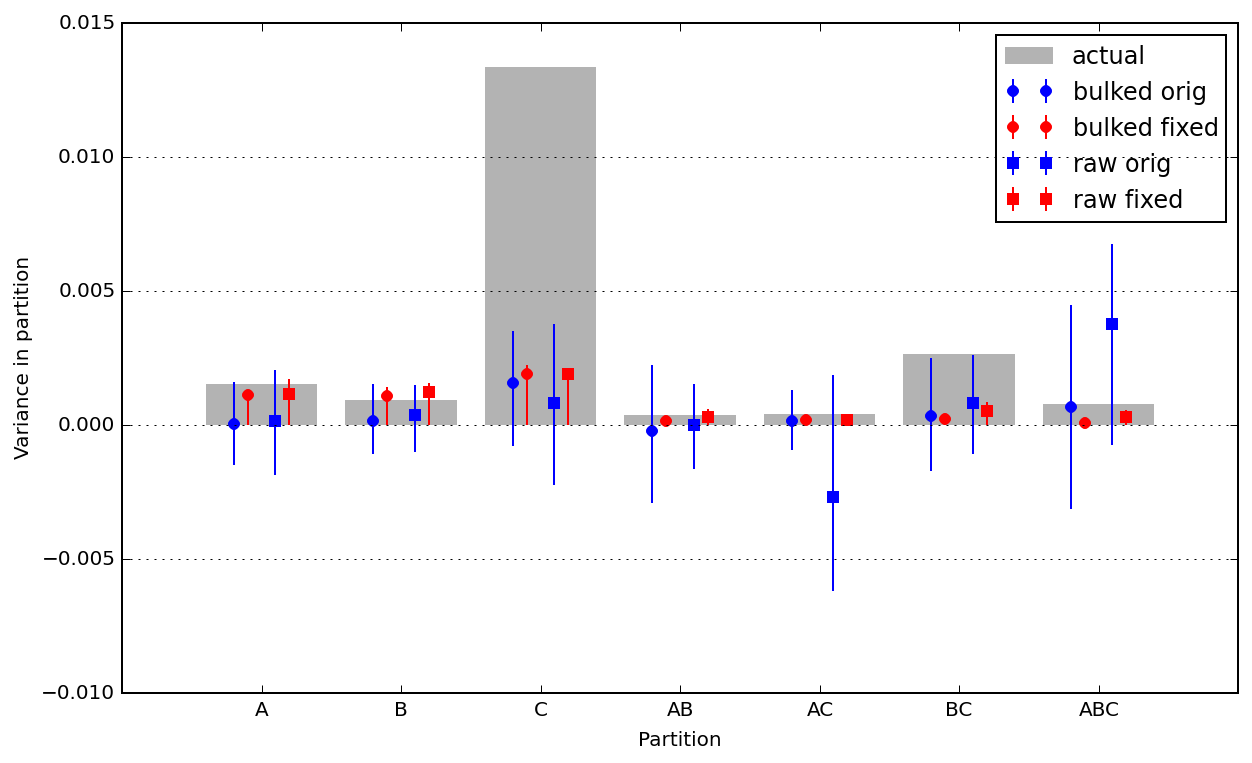

In [170]:
compare(dict(use_features="bulked"), dict(use_features="raw"), "bulked", "raw", 
        data_params, data, verbose=False)

## Compare same-size models vs. raw features

same MSE: Orig: 0.000075, Fixed: 0.000023, Ratio: fixed 3.301x better
raw MSE:  Orig: 0.000063, Fixed: 0.000024, Ratio: fixed 2.579x better

same vs. raw fixed MSE: same 1.077x better

same Variance: Orig: 0.000055, Fixed: 0.000004, Ratio: fixed 15.258x better
raw Variance: Orig: 0.000037, Fixed: 0.000005, Ratio: fixed 7.617x better

same vs. raw fixed variance: same 1.345x better

same Bias: 
Orig: [ -1.25192522e-03  -5.87206492e-04  -1.13834704e-02   8.60601850e-05
  -5.02103741e-04  -2.43183944e-03  -7.26336640e-04], 
Fixed: [-0.00053411 -0.00011448 -0.01127196 -0.00016854 -0.00015712 -0.00232223
 -0.00068944], 
Ratio: fixed 1.112x better

raw Bias: 
Orig: [-0.0013742  -0.00055928 -0.01253986 -0.00035543 -0.00310759 -0.00183968
  0.00297921], 
Fixed: [ -3.57847866e-04   2.98177425e-04  -1.14788674e-02  -4.81277644e-05
  -2.28245638e-04  -2.09534810e-03  -5.30435036e-04], 
Ratio: fixed 1.513x better

same vs. raw fixed bias: same 0.986x better


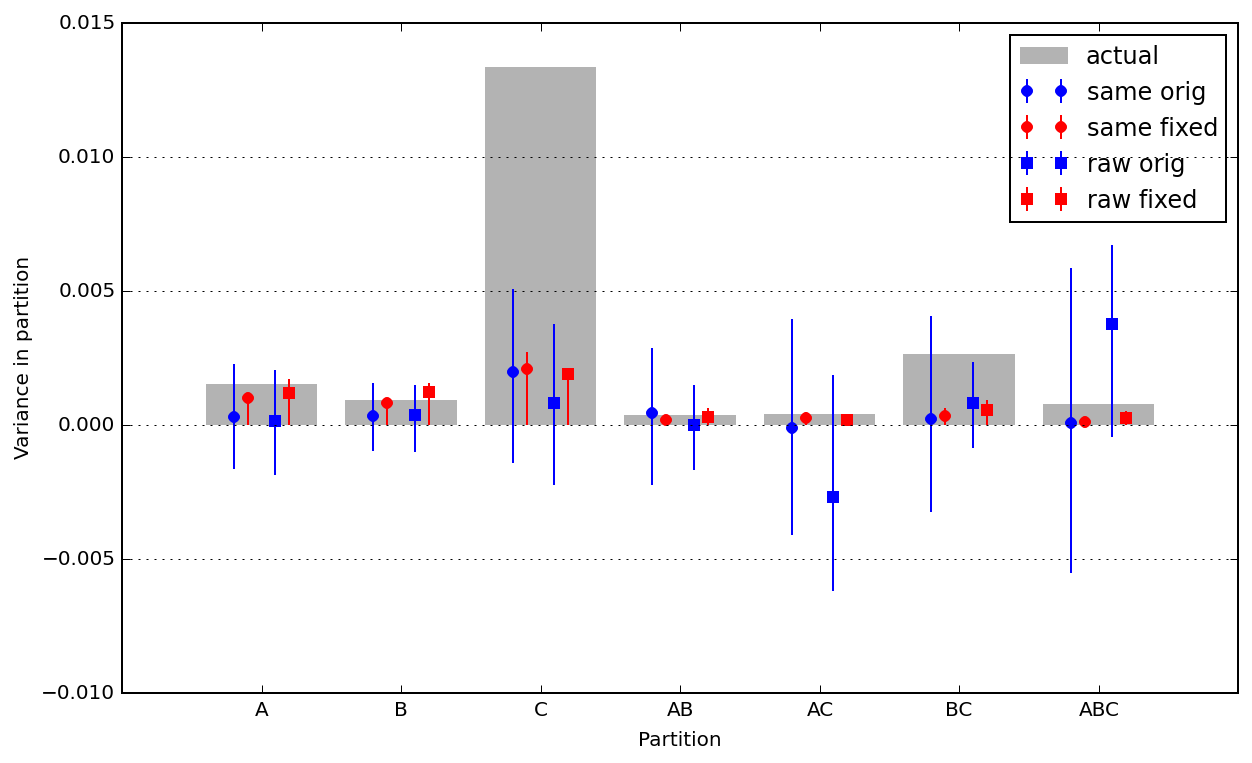

In [171]:
compare(dict(use_features="same"), dict(use_features="raw"), "same", "raw", 
        data_params, data, verbose=False)

## Compare L2 vs. L1 bias minimization in correction

min-L2-bias MSE: Orig: 0.000064, Fixed: 0.000024, Ratio: fixed 2.613x better
min-L1-bias MSE:  Orig: 0.000065, Fixed: 0.000032, Ratio: fixed 2.009x better

min-L2-bias vs. min-L1-bias fixed MSE: min-L2-bias 1.318x better

min-L2-bias Variance: Orig: 0.000038, Fixed: 0.000005, Ratio: fixed 7.699x better
min-L1-bias Variance: Orig: 0.000039, Fixed: 0.000013, Ratio: fixed 2.895x better

min-L2-bias vs. min-L1-bias fixed variance: min-L2-bias 2.718x better

min-L2-bias Bias: 
Orig: [-0.0013742  -0.00055928 -0.01256792 -0.00038068 -0.00307952 -0.00180973
  0.0029745 ], 
Fixed: [ -3.69330819e-04   3.03026646e-04  -1.14686418e-02  -6.66223943e-05
  -2.08721003e-04  -2.10671175e-03  -5.15638532e-04], 
Ratio: fixed 1.512x better

min-L1-bias Bias: 
Orig: [-0.0013742  -0.00055928 -0.01256792 -0.00035167 -0.00307952 -0.00181162
  0.00294738], 
Fixed: [  1.90690603e-04   2.35709379e-03  -1.10304967e-02  -8.40785922e-05
  -2.42774971e-04  -2.01500176e-03  -5.66249703e-04], 
Ratio: fixed 1.376x bett

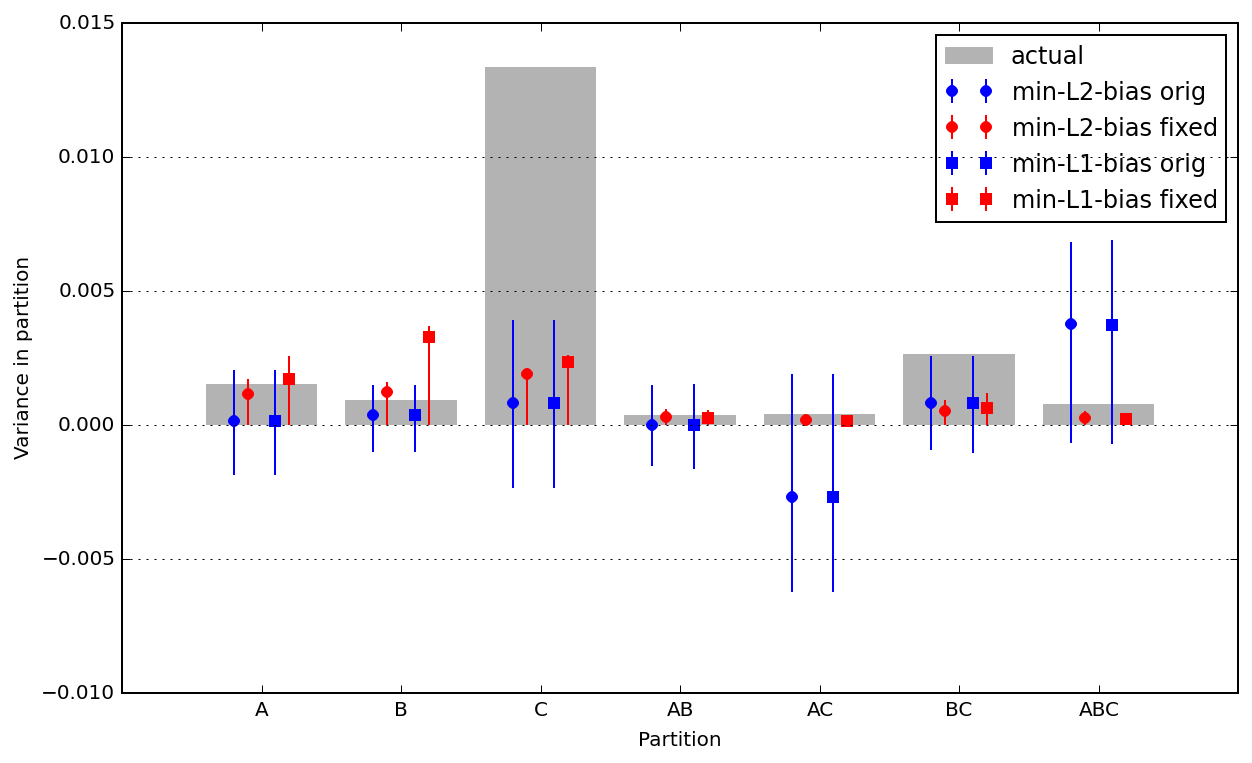

In [172]:
compare(dict(minimize="l2"), dict(minimize="l1"), "min-L2-bias", "min-L1-bias", 
        data_params, data, verbose=False)